# 1. Introducción

El objetivo de este proyecto es diseñar, construir, programar y desplegar un Sistema de Recuperación de Información (SRI) utilizando el corpus Reuters-21578. El proyecto se dividirá en varias fases, que se describen a continuación:


In [1]:
import os
import re
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 2. Fases del Proyecto

## 2.1. Adquisición de Datos

**Objetivo:** Obtener y preparar el corpus Reuters-21578.

**Tareas:**
- Descargar el corpus Reuters-21578.
- Descomprimir y organizar los archivos.
- Documentar el proceso de adquisición de datos.

## 2.2. Preprocesamiento

**Objetivo:** Limpiar y preparar los datos para su análisis.

**Tareas:**
- Extraer el contenido relevante de los documentos.
- Realizar limpieza de datos: eliminación de caracteres no deseados, normalización de texto, etc.
- Tokenización: dividir el texto en palabras o tokens.
- Eliminar stop words y aplicar stemming o lematización.
- Documentar cada paso del preprocesamiento.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
Corpus = "/content/drive/MyDrive/reuters/training"
documentos = {}

In [4]:
with open('/content/drive/MyDrive/reuters/stopwords', 'r', encoding='ascii') as file:
    stop_words = set(word.strip() for word in file.readlines())

In [5]:
def lmp(texto):
  #Normalización
  cleaned_text = re.sub(r'[^\w\s]', '', texto)
  cleaned_text = cleaned_text.lower()
  words = cleaned_text.split()
 # Steaming
  stemmer = PorterStemmer()
  stemmed_words = [stemmer.stem(word) for word in words]
# Eliminar stopwords
  filtered_words = [word for word in stemmed_words if word not in stop_words]
  cleaned_text = ' '.join(filtered_words)
  return cleaned_text

In [6]:
for filename in os.listdir(Corpus):
    filepath = os.path.join(Corpus, filename)
    with open(filepath, 'r', encoding='ascii') as file:
        text = file.read()
        cleaned_text = lmp(text)
        documentos[filename] = cleaned_text

In [7]:
for filename, cleaned_text in documentos.items():
    print(f"Filename: {filename}")
    print(f"Cleaned Text: {cleaned_text}\n")

Se han truncado las últimas 5000 líneas del flujo de salida.

Filename: 42
Cleaned Text: ico produc present coffe propos intern coffe organ ico produc countri present propos reintroduc export quota 12 month april 1 firm undertak tri negoti septemb 30 ani futur quota distribut basi ico deleg distribut april 1 unchang basi earlier produc propos includ shortfal redistribut total 122 mln bag resumpt ico contact group meet consum schedul thi ha postpon tomorrow deleg

Filename: 4199
Cleaned Text: ccc realloc credit guarante el salvador commod credit corpor ccc ha realloc mln dlr credit gurante previous earmark sale protein meal cover sale veget oil tallow el salvador agricultur depart action reduc coverag sale protein meal 14 mln dlr 16 mln dlr creat line mln dlr tallow andor greas mln dlr veget oil depart sale credit guarante line regist export sepemb 30 1987 guarante rate includ charg provid yearli interest rate coverag 45 pct guarante valu depart

Filename: 4152
Cleaned Text: retail sale

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## 2.3. Representación de Datos en Espacio Vectorial

**Objetivo:** Convertir los textos en una forma que los algoritmos puedan procesar.

**Tareas:**
- Utilizar técnicas como Bag of Words (BoW) y TF-IDF para vectorizar el texto.
- Evaluar las diferentes técnicas de vectorización.
- Documentar los métodos y resultados obtenidos.


# BoW

In [8]:
# Vectorización Bag of Words
corpus = list(documentos.values())
vectorizer_bow = CountVectorizer()
X_bow = vectorizer_bow.fit_transform(corpus)
df_bow = pd.DataFrame(X_bow.toarray(), columns=vectorizer_bow.get_feature_names_out(), index=documentos.keys())


# TF -IDF

In [9]:
# Vectorización TF-IDF
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(corpus)
df_tf_idf = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer_tfidf.get_feature_names_out(), index=documentos.keys())

## 2.4. Indexación

**Objetivo:** Crear un índice que permita búsquedas eficientes.

**Tareas:**
- Construir un índice invertido que mapee términos a documentos.
- Implementar y optimizar estructuras de datos para el índice.
- Documentar el proceso de construcción del índice.

# Indice Invertido

In [10]:
def indice_inver(df):
    indice_invertido = {}
    for columna in df.columns:
        for index, value in df[columna].items():
            if value != 0:
                if columna not in indice_invertido:
                    indice_invertido[columna] = []
                indice_invertido[columna].append((index, value))
    return indice_invertido

In [11]:
indice_invertido_bow = indice_inver(df_bow)
indice_invertido_tf_idf = indice_inver(df_tf_idf)

In [12]:
def save_ind_inver(indice_invertido, directory, filename):
    if not os.path.exists(directory):
        os.makedirs(directory)
    filepath = os.path.join(directory, filename)
    with open(filepath, 'w') as file:
        for termino, documentos in indice_invertido.items():
            file.write(f"Termino: {termino}\n")
            for documento, frecuencia in documentos:
                file.write(f"Documento: {documento}, Frecuencia: {frecuencia}\n")
            file.write("\n")

In [13]:
save_ind_inver(indice_invertido_bow, '/content/drive/MyDrive/reuters/bow', 'indice_invertido_bow.txt')
save_ind_inver(indice_invertido_tf_idf, '/content/drive/MyDrive/reuters/tf_idf', 'indice_invertido_tf_idf.txt')

In [14]:
def load_inverted_index_from_txt(filepath):
    inverted_index = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        current_term = None
        for line in file:
            line = line.strip()
            if line.startswith("Termino:"):
                current_term = line.split("Termino: ")[1]
                inverted_index[current_term] = []
            elif line.startswith("Documento:"):
                doc_info = line.split("Documento: ")[1]
                doc_name, weight = doc_info.split(", Frecuencia: ")
                inverted_index[current_term].append((doc_name, float(weight)))
    return inverted_index

inverted_index_bow_loaded = load_inverted_index_from_txt('/content/drive/MyDrive/reuters/bow/indice_invertido_bow.txt')
inverted_index_tf_idf_loaded = load_inverted_index_from_txt('/content/drive/MyDrive/reuters/tf_idf/indice_invertido_tf_idf.txt')

## 2.5. Diseño del Motor de Búsqueda

**Objetivo:** Implementar la funcionalidad de búsqueda.

**Tareas:**
- Desarrollar la lógica para procesar consultas de usuarios.
- Implementar algoritmos de similitud como similitud coseno o Jaccard.
- Desarrollar un algoritmo de ranking para ordenar los resultados.
- Documentar la arquitectura y los algoritmos utilizados.

In [15]:
def process_query(query):
    cleaned_query = lmp(query)
    return cleaned_query.split()

def jaccard_similarity(query_tokens, document_tokens):
    intersection = len(set(query_tokens) & set(document_tokens))
    union = len(set(query_tokens) | set(document_tokens))
    return intersection / union if union != 0 else 0  # Avoid division by zero

def cosine_similarity_score(vector1, vector2):
    return cosine_similarity([vector1], [vector2])[0][0]

def search_with_bow(query, inverted_index_bow, documents):
    query_tokens = process_query(query)
    doc_tokens = {doc_id: documentos[doc_id].split() for doc_id in documentos}
    scores = {}
    for doc_id in doc_tokens:
        scores[doc_id] = jaccard_similarity(query_tokens, doc_tokens[doc_id])
    ranked_results = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return ranked_results

def search_with_tfidf(query, tfidf_matrix, vectorizer_tfidf, documents):
    query_tokens = process_query(query)
    query_vector = vectorizer_tfidf.transform([' '.join(query_tokens)]).toarray()[0]
    scores = {}
    for idx, doc_id in enumerate(documents.keys()):
        doc_vector = tfidf_matrix[idx].toarray()[0]
        scores[doc_id] = cosine_similarity_score(query_vector, doc_vector)
    ranked_results = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return ranked_results

# Ejemplo de uso
query = "copper"

# Búsqueda con Bag of Words
results_bow = search_with_bow(query, inverted_index_bow_loaded, documentos)
print("Resultados con Bag of Words:")
for doc_id, score in results_bow[:5]:  # Mostrar los 5 documentos más relevantes
    print(f"Documento: {doc_id}, Similitud Jaccard: {score}")

# Búsqueda con TF-IDF
results_tfidf = search_with_tfidf(query, X_tfidf, vectorizer_tfidf, documentos)
print("\nResultados con TF-IDF:")
for doc_id, score in results_tfidf[:5]:  # Mostrar los 5 documentos más relevantes
    print(f"Documento: {doc_id}, Similitud Coseno: {score}")


Resultados con Bag of Words:
Documento: 14805, Similitud Jaccard: 0.07692307692307693
Documento: 12910, Similitud Jaccard: 0.0625
Documento: 13694, Similitud Jaccard: 0.0625
Documento: 14476, Similitud Jaccard: 0.0625
Documento: 14499, Similitud Jaccard: 0.0625

Resultados con TF-IDF:
Documento: 1148, Similitud Coseno: 0.5699104343336253
Documento: 2764, Similitud Coseno: 0.5259064750189254
Documento: 12980, Similitud Coseno: 0.4766155931454833
Documento: 22, Similitud Coseno: 0.47224481100085874
Documento: 14476, Similitud Coseno: 0.45596389846364055


In [16]:
# Ejemplo de uso
query = "coffee"

# Búsqueda con Bag of Words
results_bow = search_with_bow(query, inverted_index_bow_loaded, documentos)
print("Resultados con Bag of Words:")
for doc_id, score in results_bow[:20]:  # Mostrar los 5 documentos más relevantes
    print(f"Documento: {doc_id}, Similitud Jaccard: {score}")

# Búsqueda con TF-IDF
results_tfidf = search_with_tfidf(query, X_tfidf, vectorizer_tfidf, documentos)
print("\nResultados con TF-IDF:")
for doc_id, score in results_tfidf[:20]:  # Mostrar los 5 documentos más relevantes
    print(f"Documento: {doc_id}, Similitud Coseno: {score}")


Resultados con Bag of Words:
Documento: 12008, Similitud Jaccard: 0.1
Documento: 1910, Similitud Jaccard: 0.07692307692307693
Documento: 13242, Similitud Jaccard: 0.05555555555555555
Documento: 2954, Similitud Jaccard: 0.041666666666666664
Documento: 9265, Similitud Jaccard: 0.04
Documento: 6912, Similitud Jaccard: 0.03333333333333333
Documento: 13201, Similitud Jaccard: 0.03333333333333333
Documento: 7888, Similitud Jaccard: 0.03125
Documento: 10682, Similitud Jaccard: 0.03125
Documento: 5334, Similitud Jaccard: 0.030303030303030304
Documento: 5238, Similitud Jaccard: 0.030303030303030304
Documento: 13190, Similitud Jaccard: 0.030303030303030304
Documento: 3040, Similitud Jaccard: 0.029411764705882353
Documento: 75, Similitud Jaccard: 0.02857142857142857
Documento: 5491, Similitud Jaccard: 0.027777777777777776
Documento: 5002, Similitud Jaccard: 0.027777777777777776
Documento: 12843, Similitud Jaccard: 0.027777777777777776
Documento: 13834, Similitud Jaccard: 0.027777777777777776
Docu

## 2.6. Evaluación del Sistema

**Objetivo:** Medir la efectividad del sistema.

**Tareas:**
- Definir un conjunto de métricas de evaluación (precisión, recall, F1-score).
- Realizar pruebas utilizando el conjunto de prueba del corpus.
- Comparar el rendimiento de diferentes configuraciones del sistema.
- Documentar los resultados y análisis.

In [21]:
import collections
def crear_diccionario_categorias(archivo):
    # Creamos un diccionario para almacenar las categorías y sus documentos
    categorias = collections.defaultdict(list)
    with open(archivo, 'r') as file:
        for linea in file:
            # Separamos la línea en la ruta del documento y las categorías
            ruta, *cats = linea.strip().split()
            # Extraemos el número del documento de la ruta
            numero_documento = ruta.split('/')[1]
            # Añadimos el número del documento a cada categoría correspondiente
            for cat in cats:
                categorias[cat].append(numero_documento)

    # Crear un diccionario de documentos a categorías (invirtiendo el anterior)
    documentos_categorias = collections.defaultdict(list)
    for categoria, docs in categorias.items():
        for doc in docs:
            documentos_categorias[doc].append(categoria)

    return documentos_categorias, list(categorias.keys())

# Suponiendo que tu archivo se llama 'documentos.txt'
archivo = '/content/drive/MyDrive/reuters/cats.txt'
documentos_categorias, lista_categorias = crear_diccionario_categorias(archivo)

In [22]:
def obtener_etiquetas_verdaderas(documentos, query_categoria):
    etiquetas_verdaderas = []
    for doc_id in documentos:
        if query_categoria in documentos_categorias[doc_id]:
            etiquetas_verdaderas.append(0)
        else:
            etiquetas_verdaderas.append(1)
    return etiquetas_verdaderas

def obtener_etiquetas_predichas(resultados):
    return [0 if score > 0 else 1 for _, score in resultados]

In [23]:
def evaluar_bow(query, query_categoria, inverted_index_bow, documentos):
    resultados = search_with_bow(query, inverted_index_bow, documentos)
    documentos_resultados = [doc_id for doc_id, _ in resultados]
    etiquetas_verdaderas = obtener_etiquetas_verdaderas(documentos_resultados, query_categoria)
    etiquetas_predichas = obtener_etiquetas_predichas(resultados)
    return etiquetas_verdaderas, etiquetas_predichas

def evaluar_tfidf(query, query_categoria, tfidf_matrix, vectorizer_tfidf, documentos):
    resultados = search_with_tfidf(query, tfidf_matrix, vectorizer_tfidf, documentos)
    documentos_resultados = [doc_id for doc_id, _ in resultados]
    etiquetas_verdaderas = obtener_etiquetas_verdaderas(documentos_resultados, query_categoria)
    etiquetas_predichas = obtener_etiquetas_predichas(resultados)
    return etiquetas_verdaderas, etiquetas_predichas

In [28]:
def mostrar_matriz_confusion(y_true, y_pred, categorias):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categorias, yticklabels=categorias)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Matriz de Confusión Global')
    plt.show()

In [25]:
y_true_bow = []
y_pred_bow = []
y_true_tfidf = []
y_pred_tfidf = []

for categoria in lista_categorias:
    query = categoria
    # Evaluar BOW
    etiquetas_verdaderas_bow, etiquetas_predichas_bow = evaluar_bow(query, categoria, inverted_index_bow_loaded, documentos)
    y_true_bow.extend(etiquetas_verdaderas_bow)
    y_pred_bow.extend(etiquetas_predichas_bow)

    # Evaluar TF-IDF
    etiquetas_verdaderas_tfidf, etiquetas_predichas_tfidf = evaluar_tfidf(query, categoria, X_tfidf, vectorizer_tfidf, documentos)
    y_true_tfidf.extend(etiquetas_verdaderas_tfidf)
    y_pred_tfidf.extend(etiquetas_predichas_tfidf)

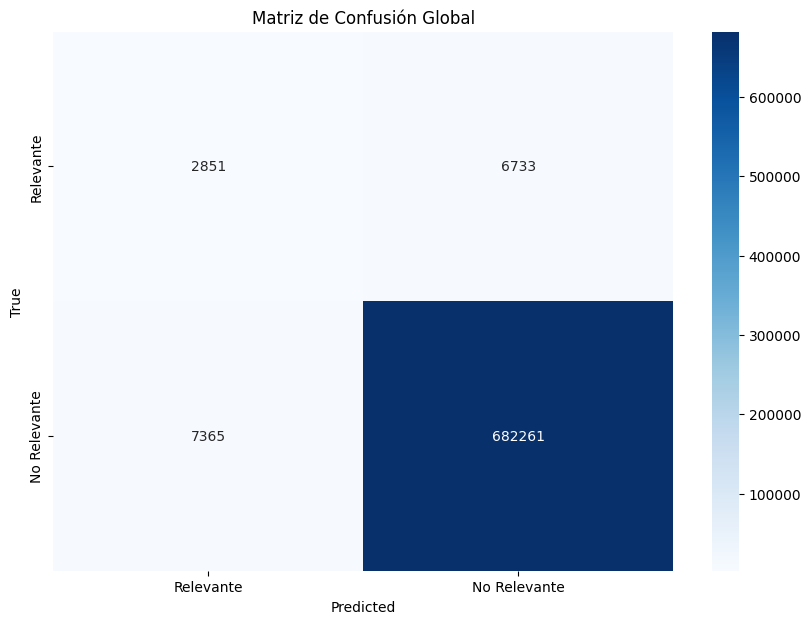

Reporte de clasificación global para Bag of Words:
              precision    recall  f1-score   support

   Relevante       0.28      0.30      0.29      9584
No Relevante       0.99      0.99      0.99    689626

    accuracy                           0.98    699210
   macro avg       0.63      0.64      0.64    699210
weighted avg       0.98      0.98      0.98    699210



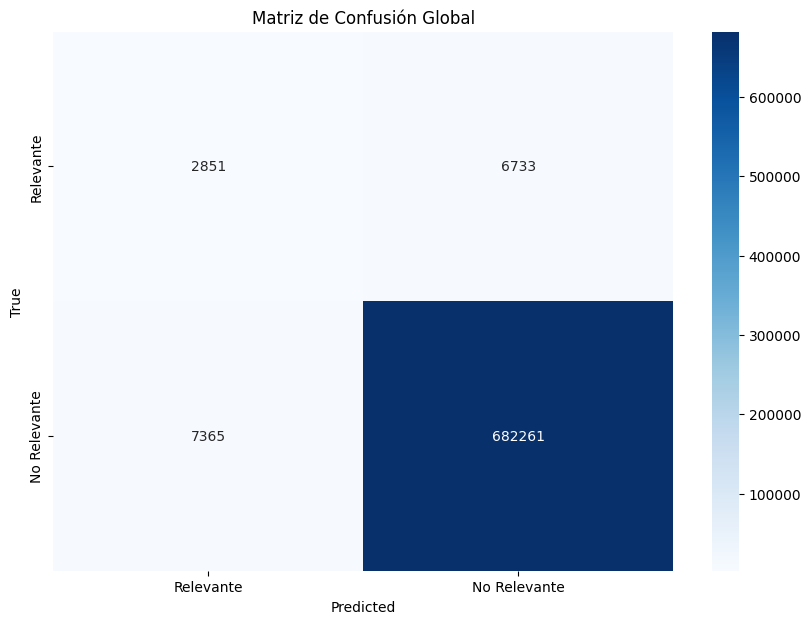

Reporte de clasificación global para TF-IDF:
              precision    recall  f1-score   support

   Relevante       0.28      0.30      0.29      9584
No Relevante       0.99      0.99      0.99    689626

    accuracy                           0.98    699210
   macro avg       0.63      0.64      0.64    699210
weighted avg       0.98      0.98      0.98    699210



In [29]:
import seaborn as sns

def mostrar_matriz_confusion(y_true, y_pred, categorias):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[ categorias, 'No ' +categorias], yticklabels=[ categorias, 'No ' +categorias])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Matriz de Confusión Global')
    plt.show()

# Mostrar matriz de
def mostrar_matriz_confusion(y_true, y_pred, categorias):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[ categorias, 'No ' +categorias], yticklabels=[ categorias, 'No ' +categorias])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Matriz de Confusión Global')
    plt.show()

# Mostrar matriz de confusión para BOW
mostrar_matriz_confusion(y_true_bow, y_pred_bow, 'Relevante')
print("Reporte de clasificación global para Bag of Words:")
print(classification_report(y_true_bow, y_pred_bow, target_names=['Relevante', 'No Relevante']))

# Mostrar matriz de confusión para TF-IDF
mostrar_matriz_confusion(y_true_tfidf, y_pred_tfidf, 'Relevante')
print("Reporte de clasificación global para TF-IDF:")
print(classification_report(y_true_tfidf, y_pred_tfidf, target_names=['Relevante', 'No Relevante']))